In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [ ]:
model = YOLO("모델 경로")
image_path = "이미지 경로"
depth_path = "depth 경로"


image 1/1 /mnt/nas4/lsj/Tire-test/yolo11-test-measure/data/image.jpg: 640x480 1 tire, 49.5ms
Speed: 5.8ms preprocess, 49.5ms inference, 114.3ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /mnt/nas4/lsj/Tire-test/test-predict/test-result46
1 label saved to /mnt/nas4/lsj/Tire-test/test-predict/test-result46/labels
결과 ultralytics.engine.results.Keypoints object with attributes:

conf: tensor([[0.8955, 0.6999, 0.8772, 0.8721]], device='cuda:0')
data: tensor([[[2.5117e+02, 1.1310e+03, 8.9552e-01],
         [1.3392e+03, 1.0951e+03, 6.9987e-01],
         [7.9663e+02, 4.8057e+02, 8.7715e-01],
         [8.3643e+02, 1.6060e+03, 8.7212e-01]]], device='cuda:0')
has_visible: True
orig_shape: (1920, 1440)
shape: torch.Size([1, 4, 3])
xy: tensor([[[ 251.1713, 1130.9510],
         [1339.2063, 1095.1052],
         [ 796.6258,  480.5696],
         [ 836.4272, 1606.0410]]], device='cuda:0')
xyn: tensor([[[0.1744, 0.5890],
         [0.9300, 0.5704],
         [0.5532, 0.2503],
       

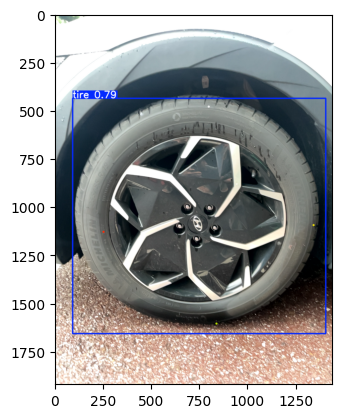

In [ ]:

# 2. 추론 실행
results = model.predict(
    source= image_path,  # 이미지 경로
    imgsz=640,                                    # 이미지 사이즈
    project=' ',  # 결과 저장 프로젝트 폴더
    name='test-result',                          # 결과 저장 폴더 이름
    save=True,                                    # 이미지 저장
    save_txt=True                                 # keypoints 좌표 저장 (원하면)
) 

# 3. 결과 확인 (선택)
for r in results:
    print(f"결과 {r.keypoints[0]}")# 키포인트 정보 출력 (옵션)

#detected_points = r.keypoints[0].xy.cpu().numpy().astype(np.int32) #-> 이건 배치차원이 포함된 3차원형태
detected_points = r.keypoints[0].xy.squeeze(0).cpu().numpy().astype(np.int32) # -> 배치차원을 제거하고 2차원 형태로 변환 xy.squeeze(0) # 배치 차원 제거
print(f"검출된 키포인트 좌표: {detected_points}")

imt = r.plot()
result_img = cv2.cvtColor(imt, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 이미지를 읽으므로 RGB로 변환
plt.imshow(result_img) 

(4, 2)


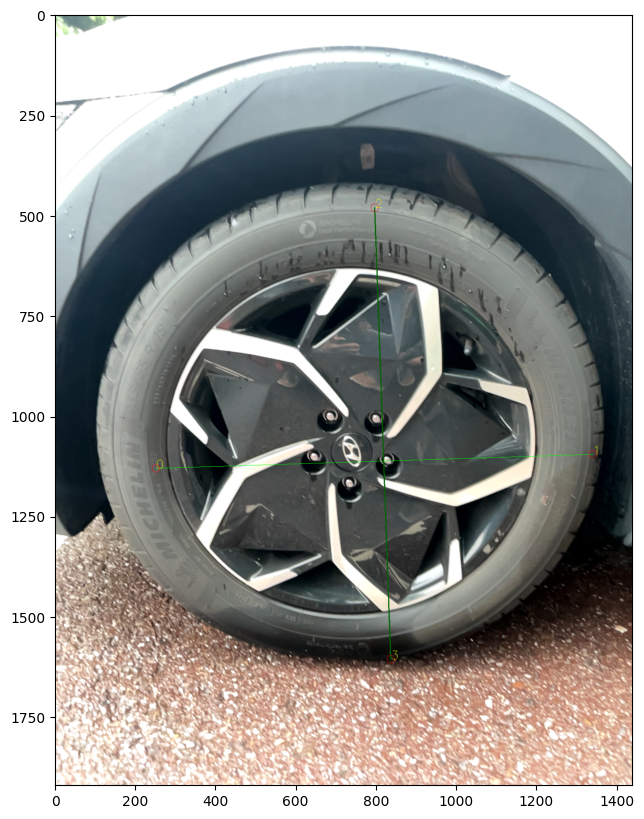

In [6]:
img = cv2.imread(image_path)
print(detected_points.shape)

cv2.line(img, tuple(detected_points[0]),tuple(detected_points[1]), (0, 255, 0), 1) # 첫 번째와 두 번째 키포인트를 연결하는 선 그리기
cv2.line(img, detected_points[2], detected_points[3], (0, 100, 0), 2) # 세 번째와 네 번째 키포인트를 연결하는 선 그리기

for idx, point in enumerate(tuple(detected_points)): #enumerate를 사용하여 인덱스와 좌표를 동시에 가져옴
    cv2.circle(img, point, 10, (0, 0, 255), 1) #원그리기
    #img를 불러와서 point좌표(x,y)튜플로 사용하기
    #원의 반지름을 10주고 색상을 0,0,255로 설정
    #-1은 원을 채우는 것을 의미
    cv2.putText(img, str(idx), point, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1) #이미지에 인덱스 번호 표시
    #img: 텍스트를 쓸 대상 이미지이며 str(idx)는 쓸 텍스트 내용인데 여기서는 키포인트 번호로 사용
    #point는 텍스트 시작 좌표이며 cv2.FONT_HERSHEY_SIMPLEX는 글꼴 종류
    #2는 글자 크기, (0, 255, 255)는 글자 색상, 2는 글자 두께를 의미
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV는 BGR로 이미지를 읽으므로 RGB로 변환
plt.figure(figsize=(10, 10)) # 이미지 크기 설정
plt.imshow(img_rgb) # 이미지를 matplotlib로 표시
#plt.show() # 이미지 표시

In [7]:
print(detected_points)
print(detected_points.dtype)

[[ 251 1130]
 [1339 1095]
 [ 796  480]
 [ 836 1606]]
int32


## 03-01. Read depth.json

In [8]:
import json
import numpy as np


def read_json(fpath):
    """
    JSON 파일을 읽어서 딕셔너리로 반환하는 함수

    Args:
        fpath (str): JSON 파일 경로

    Returns:
        dict: JSON 내용을 담은 파이썬 딕셔너리
    """
    with open(fpath, "r", encoding="utf-8") as f:
        j = json.load(f)
    return j


def get_world_xyz_arr(pc_path, rgb_h=1920, depth_w=256, depth_h=192):
    """
    LiDAR로부터 추출된 뎁스 정보(JSON)를 기반으로 월드 좌표계 기준의 [x, y, z] 포인트 배열을 생성함.

    현재 LiDAR Depth 해상도는 (256, 192)
    반환되는 world_xyz_arr의 shape는 (256, 192, 3)

    주요 개념:
    - z: 거리 (깊이)
    - x, y: 각 점이 이미지 내 어디 위치했는지를 기반으로 거리로 변환
    - 카메라 좌표계를 실제 세계 좌표계로 변환하기 위해 3x3 회전행렬 + 3x1 이동벡터를 적용
    - 최종적으로 world_xyz_arr는 실제 거리 기반의 포인트 클라우드 배열이 됨

    Args:
        pc_path (str): LiDAR가 생성한 JSON 포인트 클라우드 파일 경로
        rgb_h (int): RGB 이미지의 세로 해상도 (기본값: 1920)
        depth_w (int): 뎁스 이미지의 가로 픽셀 수 (기본값: 256)
        depth_h (int): 뎁스 이미지의 세로 픽셀 수 (기본값: 192)

    Returns:
        np.ndarray: (256, 192, 3) 형태의 [x, y, z] 값을 가지는 3차원 배열
    """

    # 1. JSON 파일 읽기
    pc_json = read_json(pc_path)

    # 2. focal length (초점 거리)
    fl_x = pc_json["fl"]["x"] 
    fl_y = pc_json["fl"]["y"]

    # 3. RGB 해상도 대비 뎁스 해상도 비율
    rgb_depth_ratio = rgb_h / depth_w  # = 1920 / 256 = 7.5
    #이 부분 내꺼에서 h로 수정

    # 4. 뎁스 값 리스트 (길이 = 256 * 192 = 49,152개)
    depth_values = pc_json["Depth"]

    # 5. 각 픽셀의 (x, y, z) 좌표 계산 (카메라 좌표계 기준)
    #뎁스 이미지 속 모든 픽셀을 한 번씩 다 순회하면서 각각의 픽셀에 대해 (x,y,z) 좌표를 계산
    #2D 뎁스 이미지 값을 3D 공간의 좌표로 변환해주는 과정
    xyz_array = []
    k = 0  # depth_values 인덱스
    for i in range(depth_h):  # y축 방향
        for j in range(depth_w):  # x축 방향
            z = depth_values[k]
            # 픽셀 위치를 기반으로 실세계 거리로 변환 (중심 기준 정규화)
            x = (j - depth_w / 2) * z / (fl_x / rgb_depth_ratio)
            y = (i - depth_h / 2) * z / (fl_y / rgb_depth_ratio)
            xyz_array.append([x, y, z])
            k += 1
    #이때까지는 아직 카메라(센서) 기준 좌표계에서의 3D위치
    
    #6. 월드 좌표계로 변환을 위한 4x4 행렬
    R_camera_to_world = np.array(
        [ 
            [pc_json["m00"], pc_json["m01"], pc_json["m02"], pc_json["m03"]],
            [pc_json["m10"], pc_json["m11"], pc_json["m12"], pc_json["m13"]],
            [pc_json["m20"], pc_json["m21"], pc_json["m22"], pc_json["m23"]],
            [pc_json["m30"], pc_json["m31"], pc_json["m32"], pc_json["m33"]],
        ]
    )

    # 회전 행렬만 추출 (앞의 3x3)
    R_camera_to_world = R_camera_to_world[0:3, 0:3]

    # 카메라 위치(이동 벡터) 추출
    T_camera_to_world = np.array( #이건 원래 4차원 행렬로 얻을 수 있지만 유니티에서는 POS를 바로 쉽게 얻을 수 있음
        [pc_json["Pos"]["x"], pc_json["Pos"]["y"], pc_json["Pos"]["z"]]
    )

    # 7. 각 포인트를 월드 좌표계로 변환: (R @ xyz + T)
    world_xyz = np.dot(xyz_array, R_camera_to_world) + T_camera_to_world
    #카메라 또는 센서 좌표계의 3D 포인트를 월드(세계) 좌표계로 변환하는 수식 - 3D 좌표 변환의 표준 공식
    #R은 회전행렬, T는 이동행렬
    #P world​ =R⋅Pcamera+T
    #np.dot는 두 배열(벡터 또는 행렬)의 곱셉을 수행하는 것으로 np.dot(A, B) 는 A와 B를 행렬 곱셉 수행

    # 8. (높이, 너비, 3) 형태로 reshape. → 이미지처럼 처리하기 위함
    #여기서 3은 각 픽셀에 대한 3차원 좌표
    #쉽게 말하면 3차원 배열의 너비와 높이는 2차원 뎁스값과 같게 만든 것
    world_xyz_arr = world_xyz.reshape((depth_h, depth_w, 3))
    #reshape 는 배열의 모양을 바꾸는 것

    # 9. 회전 (numpy의 rot90 사용): 90도 반시계 방향으로 1번 회전
    world_xyz_arr = np.rot90(world_xyz_arr, k=-1)

    return world_xyz_arr


In [9]:
depth_json_path = depth_path
world_xyz_arr = get_world_xyz_arr(depth_json_path)
print(world_xyz_arr.shape)

(256, 192, 3)


In [10]:
print(world_xyz_arr)

[[[   -0.14363    -0.23939       -2.72]
  [   -0.14881    -0.24505      -2.716]
  [   -0.15931    -0.25207     -2.7089]
  ...
  [   -0.29968    -0.97664     -2.4597]
  [   -0.29282    -0.98458     -2.4612]
  [   -0.30226    -0.98265     -2.4569]]

 [[   -0.15948    -0.24315     -2.7153]
  [   -0.16085    -0.24773     -2.7135]
  [   -0.16073     -0.2519     -2.7125]
  ...
  [   -0.30622    -0.97507     -2.4605]
  [   -0.29725     -0.9843     -2.4627]
  [   -0.31456    -0.97751     -2.4556]]

 [[   -0.16685    -0.24459     -2.7154]
  [   -0.16357    -0.24789     -2.7163]
  [   -0.16652    -0.25288     -2.7135]
  ...
  [   -0.31023    -0.97502     -2.4621]
  [   -0.30874    -0.97971     -2.4617]
  [   -0.31503    -0.97962     -2.4585]]

 ...

 [[    -1.1083    -0.37876     -3.0998]
  [    -1.1084    -0.38283      -3.095]
  [    -1.1084    -0.38717     -3.0878]
  ...
  [    -1.1351      -1.089     -2.9657]
  [    -1.1351     -1.0906     -2.9618]
  [    -1.1356        -1.1     -2.9681]]

 [

## 03-02. Points in 2D RGB -> Points in world_xyz_arr

In [11]:
def rgbxy_to_worldxy(rgbxy, rgb_w=1440, rgb_h=1920, world_w=192, world_h=256):
    """RGB [x, y] 좌표를 비율에 따라 월드 [x, y] 좌표로 변환합니다.

Args:
    rgbxy ([x, y]): RGB 이미지 상의 [x, y] 좌표
    rgb_w (int, optional): RGB 이미지의 가로 길이. 기본값은 1440입니다.
    rgb_h (int, optional): RGB 이미지의 세로 길이. 기본값은 1920입니다.
    world_w (int, optional): world_xyz_arr 배열의 가로 길이. 기본값은 192입니다.
    world_h (int, optional): world_xyz_arr 배열의 세로 길이. 기본값은 256입니다.

Returns:
    [x, y]: 변환된 [x, y] 좌표로, 이 좌표를 사용해 world_xyz_arr[x, y]에 접근할 수 있습니다.
    """

    w_ratio = rgb_w / world_w #너비 방향의 비율
    h_ratio = rgb_h / world_h #높이 방향의 비율

    worldxy = np.array([rgbxy[0] / w_ratio, rgbxy[1] / h_ratio], dtype=np.int16)
    #rgbxy[0] 은 RGB이미지의 가로(x) 위치
    #rgbxy[1] 은 RGB이미지의 세로(y) 위치
    #rgbxy[0] / w_ratio 은 RGB x 좌표를 월드 좌표 배열 x 인덱스에 맞게 축소한것
    #rgbxy[1] / h_ratio 은 RGB y 좌표를 월드 좌표 배열 y 인덱스에 맞게 축소한것
    #보통 컴퓨터 그래픽이나 이미지 처리할때 좌표는 [x , y] 로 하는데 이떄 0인덱스는 x, 1인덱스는 y
    #나누기 계산은 보통 실수형(float)로 나오기 때문에 정수로 바꾸기

    return worldxy

In [12]:
# detected_points의 인자 각각에 rgbxy_to_worldxy 함수를 적용하여 변환한다.
detected_points_world = [rgbxy_to_worldxy(points) for points in detected_points]
detected_points_world = np.array(detected_points_world)
detected_points_world

array([[ 33, 150],
       [178, 146],
       [106,  64],
       [111, 214]], dtype=int16)

## 03-03. Measure Length

In [13]:
def calc_dist_2pts(world_xyz_arr, p1, p2, coef=100):
    """world_xyz_array(256, 192, 3) 상의 두 점 p1[x, y], p2[x, y] 사이의 거리를 계산합니다.

⚠️ 주의!!!
rgb 이미지 상의 [x, y] 좌표 기준으로 p1과 p2 사이의 거리를 계산하려면,
`world_xyz_arr[y, x]` 형태로 인덱싱해야 합니다.
==> 이 동작은 이 함수 안에 이미 포함되어 있습니다.
!!!

매개변수:
    world_xyz_arr (array): 월드 좌표계 배열 (크기: 256, 192, 3)
    p1 (list): world_xyz_arr 배열에 인덱싱하기 위한 변환된 [x, y] 좌표
    p2 (list): 위와 동일

반환값:
    float: p1과 p2 사이의 거리 (실제 거리, 단위는 해당 좌표계 기준)
    """

    w_p1 = np.array(world_xyz_arr[p1[1], p1[0]])
    w_p2 = np.array(world_xyz_arr[p2[1], p2[0]])
    dist = np.linalg.norm(w_p1 - w_p2) * coef

    return dist

In [14]:
car_width = calc_dist_2pts(
    world_xyz_arr, detected_points_world[0], detected_points_world[1]
)
car_height = calc_dist_2pts(
    world_xyz_arr, detected_points_world[2], detected_points_world[3]
)
print(f"Width Length: {car_width}, Height Length: {car_height}")

Width Length: 65.24926949753899, Height Length: 67.79542185730057


65.24926949753899
67.79542185730057


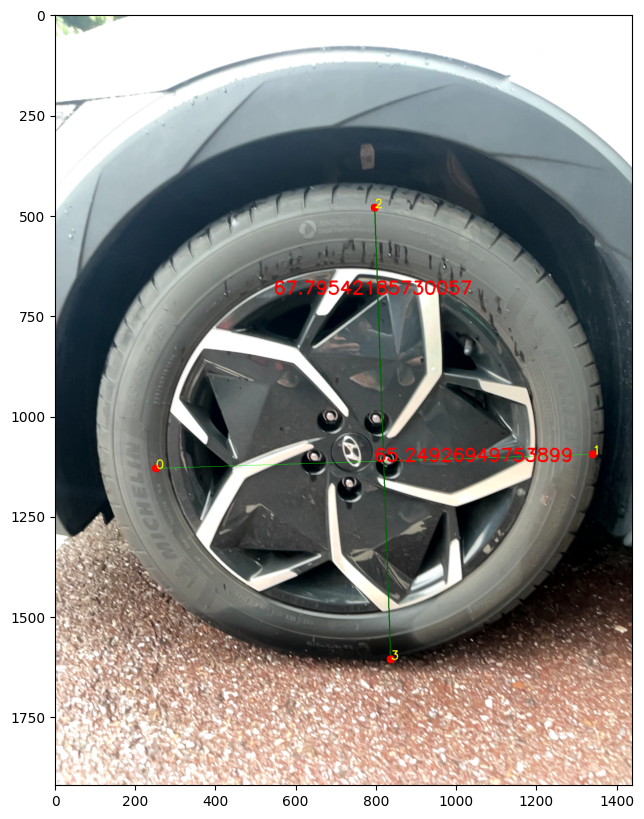

In [15]:
cv2.line(img, tuple(detected_points[0]),tuple(detected_points[1]), (0, 255, 0), 1) # 첫 번째와 두 번째 키포인트를 연결하는 선 그리기
cv2.line(img, detected_points[2], detected_points[3], (0, 100, 0), 2) # 세 번째와 네 번째 키포인트를 연결하는 선 그리기

for idx, point in enumerate(tuple(detected_points)): #enumerate를 사용하여 인덱스와 좌표를 동시에 가져옴
    cv2.circle(img, point, 10, (0, 0, 255), -1) #원그리기
    #img를 불러와서 point좌표(x,y)튜플로 사용하기
    #원의 반지름을 10주고 색상을 0,0,255로 설정
    #-1은 원을 채우는 것을 의미
    cv2.putText(img, str(idx), point, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2) #이미지에 인덱스 번호 표시
    #img: 텍스트를 쓸 대상 이미지이며 str(idx)는 쓸 텍스트 내용인데 여기서는 키포인트 번호로 사용
    #point는 텍스트 시작 좌표이며 cv2.FONT_HERSHEY_SIMPLEX는 글꼴 종류
    #2는 글자 크기, (0, 255, 255)는 글자 색상, 2는 글자 두께를 의미
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV는 BGR로 이미지를 읽으므로 RGB로 변환
# plt.figure(figsize=(10, 10)) # 이미지 크기 설정
# plt.imshow(img_rgb) # 이미지를 matplotlib로 표시

labels = [car_width, car_height]
print(car_width)
print(car_height)

# 첫 번째 선의 중간 좌표 계산
midpoint1 = ((detected_points[0][0] + detected_points[1][0]) // 2,
             (detected_points[0][1] + detected_points[1][1]) // 2)
cv2.putText(img_rgb, str(labels[0]), midpoint1, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 3)

# 두 번째 선의 중간 좌표 계산
midpoint2 = ((detected_points[2][0] + detected_points[3][0]) // 3,
             (detected_points[2][1] + detected_points[3][1]) // 3)
cv2.putText(img_rgb, str(labels[1]), midpoint2, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 3)

plt.figure(figsize=(10, 10)) # 이미지 크기 설정
plt.imshow(img_rgb)